## Stage2 (Pattern Recognition) - KMeans Clustering for IoT Pattern Similarity

### Stage 1 Non-Linear (AutoEncoder) Dimension Reduction of the 8 IoTs benign data from 115 features to 20 latent representations.

## Stage 2 Steps in Detail -
###      Input Data: 'Benign' from first 8 x IoTs: 536,404 records x 20 latent representations
###      Stage 2 (Pattern Recognition): KMeans
###                 Step 2.1 --> Calculate Inertia to identify the correct number of clusters
###                 Step 2.2 --> Visual confirmation of IoT similarities among 20 clusters
###                 Step 2.3 --> Clustering of IoT patterns to group similar IoTs, as clusters of 3 or 4 or 5 groups.
###       Results: IoTs (1,3,5,6) and (7,8) show pattern similarities among IoTs within those groups.

## Summary: Analysis show IoTs (1,3,5,6) and (7,8) can be grouped together based on pattern recognition similarities.

#### backup Ref: stage_2_ae_kmeans_9 g_20200504_01

### Stage 1 (Dimensionality Reduction): AutoEncoder
### Stage 1 - 536,404 records with 115 features -> Auto Encoder (non-linear) dimension reduction -> 536,404 x 20 latent representations (dimensions)

In [1]:
# set all random variables
import os
import numpy as np
import random
import tensorflow as tf
from keras import backend as K

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
# Import all packages required for compression and clustering
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from keras import regularizers, Model
from keras import backend

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

from scipy import spatial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import seed
seed(42)

In [3]:
#Import benign files from all nine IoT devices and capture the device information in a seperate dataframe

device1 =pd.read_csv("1.benign.csv")
device1['Device'] = 1
label1 = device1['Device']
device1 = device1.drop(['Device'], axis=1)

device2 =pd.read_csv("2.benign.csv")
device2['Device'] = 2
label2 = device2['Device']
device2 = device2.drop(['Device'], axis=1)

device3 =pd.read_csv("3.benign.csv")
device3['Device'] = 3
label3 = device3['Device']
device3 = device3.drop(['Device'], axis=1)

device4 =pd.read_csv("4.benign.csv")
device4['Device'] = 4
label4 = device4['Device']
device4 = device4.drop(['Device'], axis=1)

device5 =pd.read_csv("5.benign.csv")
device5['Device'] = 5
label5 = device5['Device']
device5 = device5.drop(['Device'], axis=1)

device6 =pd.read_csv("6.benign.csv")
device6['Device'] = 6
label6 = device6['Device']
device6 = device6.drop(['Device'], axis=1)

device7 =pd.read_csv("7.benign.csv")
device7['Device'] = 7
label7 = device7['Device']
device7 = device7.drop(['Device'], axis=1)

device8 =pd.read_csv("8.benign.csv")
device8['Device'] = 8
label8 = device8['Device']
device8 = device8.drop(['Device'], axis=1)

# Device 9 is being withheld until stage 4 and introduced as a new IoT 
# into the IoT Ecosystem and pattern similarities used to match to similar IoT cluster.


In [4]:
# Combine all the benign data into a single dataframe
all_benign = device1.append([device2,device3,device4,device5,device6,device7,device8])

# Combine all the IoT device numbers into a dataframe
labels = label1.append([label2,label3,label4,label5,label6,label7,label8])

print("Input features shape -->", all_benign.shape)
print("Labels shape --> ", labels.shape)

# delete the individual device data dataframe to release memory
del device1,device2,device3,device4,device5,device6,device7,device8

Input features shape --> (536404, 115)
Labels shape -->  (536404,)


In [5]:
# Attach the label back and reshuffle the benign data
all_benign['labels'] = labels
all_benign = all_benign.sample(frac=1, random_state=42)

In [6]:
# create a 50% training set and scale

data_size = all_benign.shape[0]//2 

train = all_benign.iloc[0:-data_size,:-1].copy()

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

In [7]:
# Definition of the loss function for the auto encoder
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Input layer for the auto encoder
input_layer = Input(shape=(train.shape[1],))

# Encoding part - From 115 features to 110 to 95 and then compress the data to 20 dimentions
encoded = Dense(110, activation='relu', activity_regularizer=regularizers.l1_l2(l1=10e-6, l2=10e-6))(input_layer)
encoded = Dense(95, activation='relu')(encoded)
encoded = Dense(20)(encoded)

# Decoding part - From 20 latent dimentions to 95 and then to 100 features
decoded = Dense(95, activation='relu')(encoded)
decoded = Dense(110, activation='relu')(decoded)

# Output layer
output_layer = Dense(train.shape[1])(decoded)

# Initialize the auto encoder with the input and output layers
autoencoder = Model(input_layer, output_layer)

# Code to compress the data into 20 latent dimentions
encoder = Model(input_layer, encoded)

# Autoencoder compile
autoencoder.compile(optimizer= 'adadelta', loss=rmse)

# fit the model
autoencoder.fit(train, train, batch_size = 100, epochs = 150,
                validation_split = 0.20)

Train on 214561 samples, validate on 53641 samples
Epoch 1/150
214561/214561 [==============================] - 5s 23us/step - loss: 0.2165 - val_loss: 0.1529
Epoch 2/150
214561/214561 [==============================] - 4s 20us/step - loss: 0.1268 - val_loss: 0.1180
Epoch 3/150
214561/214561 [==============================] - 4s 20us/step - loss: 0.1082 - val_loss: 0.1036
Epoch 4/150
214561/214561 [==============================] - 4s 19us/step - loss: 0.0988 - val_loss: 0.1136
Epoch 5/150
214561/214561 [==============================] - 4s 19us/step - loss: 0.0930 - val_loss: 0.0904
Epoch 6/150
214561/214561 [==============================] - 4s 19us/step - loss: 0.0886 - val_loss: 0.0842
Epoch 7/150
214561/214561 [==============================] - 4s 20us/step - loss: 0.0852 - val_loss: 0.0927
Epoch 8/150
214561/214561 [==============================] - 4s 20us/step - loss: 0.0824 - val_loss: 0.0823
Epoch 9/150
214561/214561 [==============================] - 5s 21us/step - loss: 0.0

Epoch 150/150
214561/214561 [==============================] - 4s 19us/step - loss: 0.0492 - val_loss: 0.0506


In [8]:
# Transform with scaler on the test data
labels = all_benign.iloc[-data_size:,-1].copy()
all_benign = all_benign.iloc[-data_size:,:-1].copy()
scaler = StandardScaler()
scaler.fit(all_benign)
all_benign = scaler.transform(all_benign)

In [9]:
# compress the test data
all_benign = encoder.predict(all_benign)

In [10]:
all_benign_copy = all_benign.copy()

In [11]:
#all_benign = all_benign_copy.copy()

### Stage 2 (Pattern Recognition): KMeans Clustering
### Apply pattern recognition techniques to find IoT similarities between 8 IoTs (IoT1 to IoT 8)

In [12]:
# Fit a K-Means on 20 latent dimentions output from autoencoder. Try multiple values of n_clusters to find the optimal clusters

inertia = []
kmeans2 = KMeans(n_clusters=2, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans2.inertia_)

kmeans10 = KMeans(n_clusters=10, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans10.inertia_)

kmeans20 = KMeans(n_clusters=20, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans20.inertia_)

kmeans30 = KMeans(n_clusters=30, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans30.inertia_)

kmeans40 = KMeans(n_clusters=40, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans40.inertia_)

kmeans50 = KMeans(n_clusters=50, random_state=0, max_iter = 1000).fit(all_benign)
inertia.append(kmeans50.inertia_)


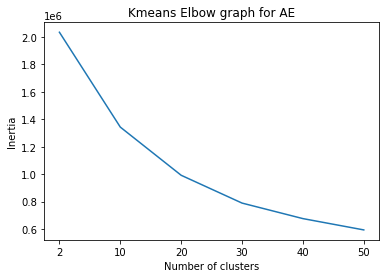

In [13]:
# Plot the kmeans elbow graph

components = ('2','10','20','30','40','50') 
plt.plot(components, inertia)
plt.title("Kmeans Elbow graph for AE")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [14]:
# adding the device id and cluster labels for kmenas with the optimal number of clusters

all_benign = pd.DataFrame(all_benign)

# Add the device number back into the dataframe
all_benign['Device'] = labels.values

all_benign['Cluster20'] = kmeans20.labels_

# Adding a counter to sum the number of rows in a pivot table
all_benign['Counter'] = 1

all_benign.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,Device,Cluster20,Counter
0,0.127736,0.091521,0.223115,0.193192,0.205927,-0.121336,-0.060004,0.118581,0.003771,0.245925,...,-0.016391,0.162385,-0.168810,0.076465,-0.060330,0.121298,-0.017458,4,15,1
1,0.123022,0.206625,0.146812,0.304626,0.166043,-0.221000,0.145870,-0.082531,0.205711,0.014585,...,0.157290,0.076837,-0.121923,0.005576,-0.003030,0.083981,0.195451,4,15,1
2,-0.513601,0.256727,0.458742,-0.000975,-0.078673,0.207077,-0.242572,-0.282587,-0.316365,-0.470118,...,0.087086,-0.290326,0.206622,0.463845,-0.420382,0.049041,-0.251521,5,0,1
3,0.044597,-0.146911,-0.150788,0.294801,-0.195166,-0.059264,0.122590,-0.605845,0.107185,-0.298558,...,0.117786,-0.033977,-0.092375,0.120374,-0.006316,0.073239,0.096171,4,0,1
4,0.522586,0.175922,-0.873103,-0.981434,-0.331390,-0.044471,0.336634,-0.125885,0.145849,0.196278,...,-0.564324,0.935978,0.484641,-0.070141,-0.528742,0.062099,0.104950,7,3,1


Summary of data points under each device cluster pair
    Device  Cluster20  Counter  Percentage
0        1          0    22953   92.964763
1        1          3        8    0.032402
2        1         10       77    0.311867
3        1         11     1585    6.419603
4        1         13       31    0.125557
..     ...        ...      ...         ...
95       8         12     2720   11.782032
96       8         13       61    0.264229
97       8         14      230    0.996275
98       8         15      170    0.736377
99       8         18      269    1.165208

[100 rows x 4 columns]


C:\Users\sures\Anaconda3\envs\Tensorflow\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


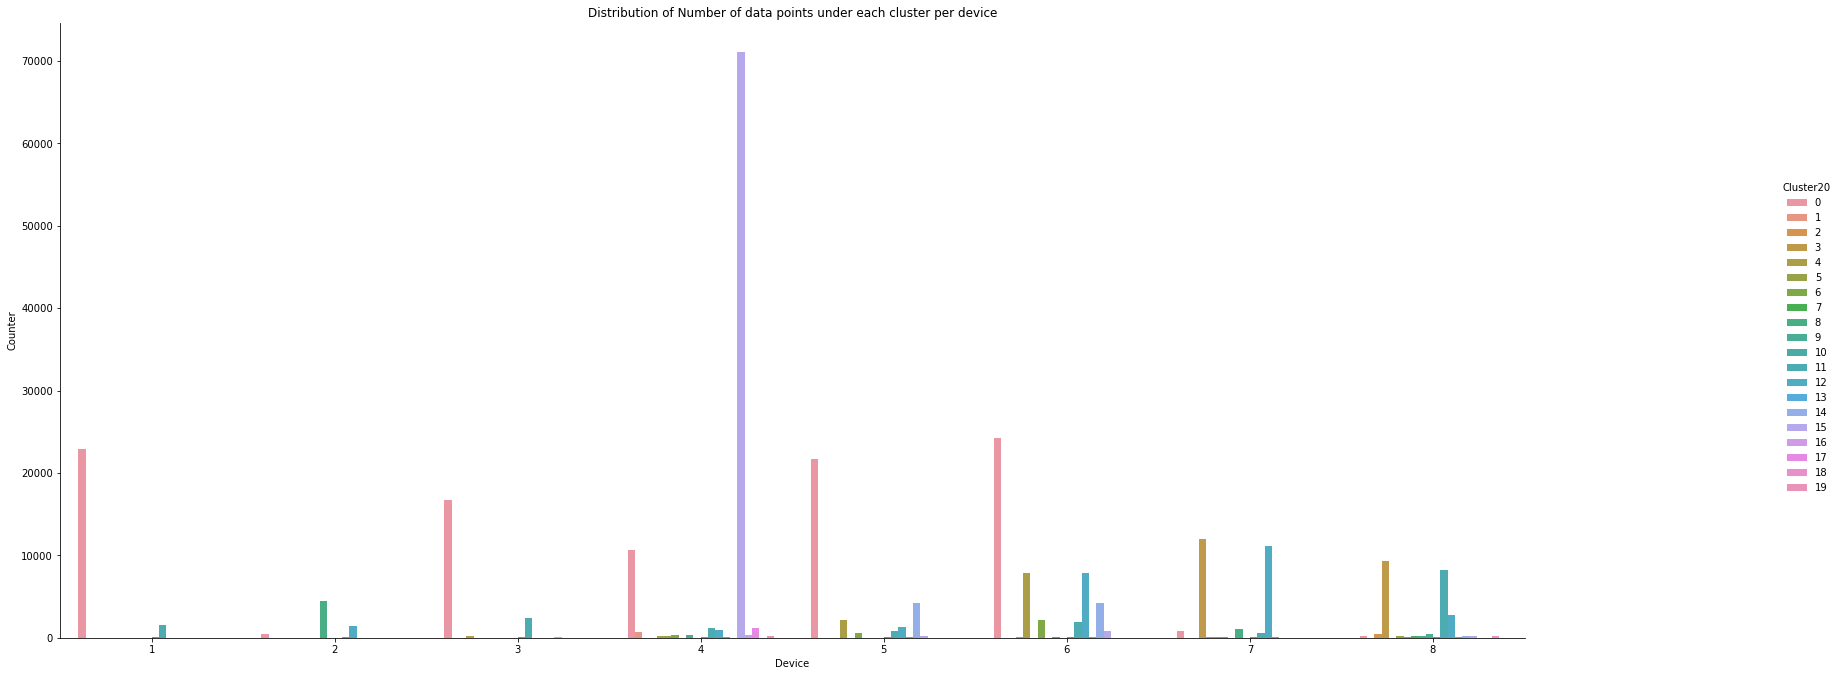

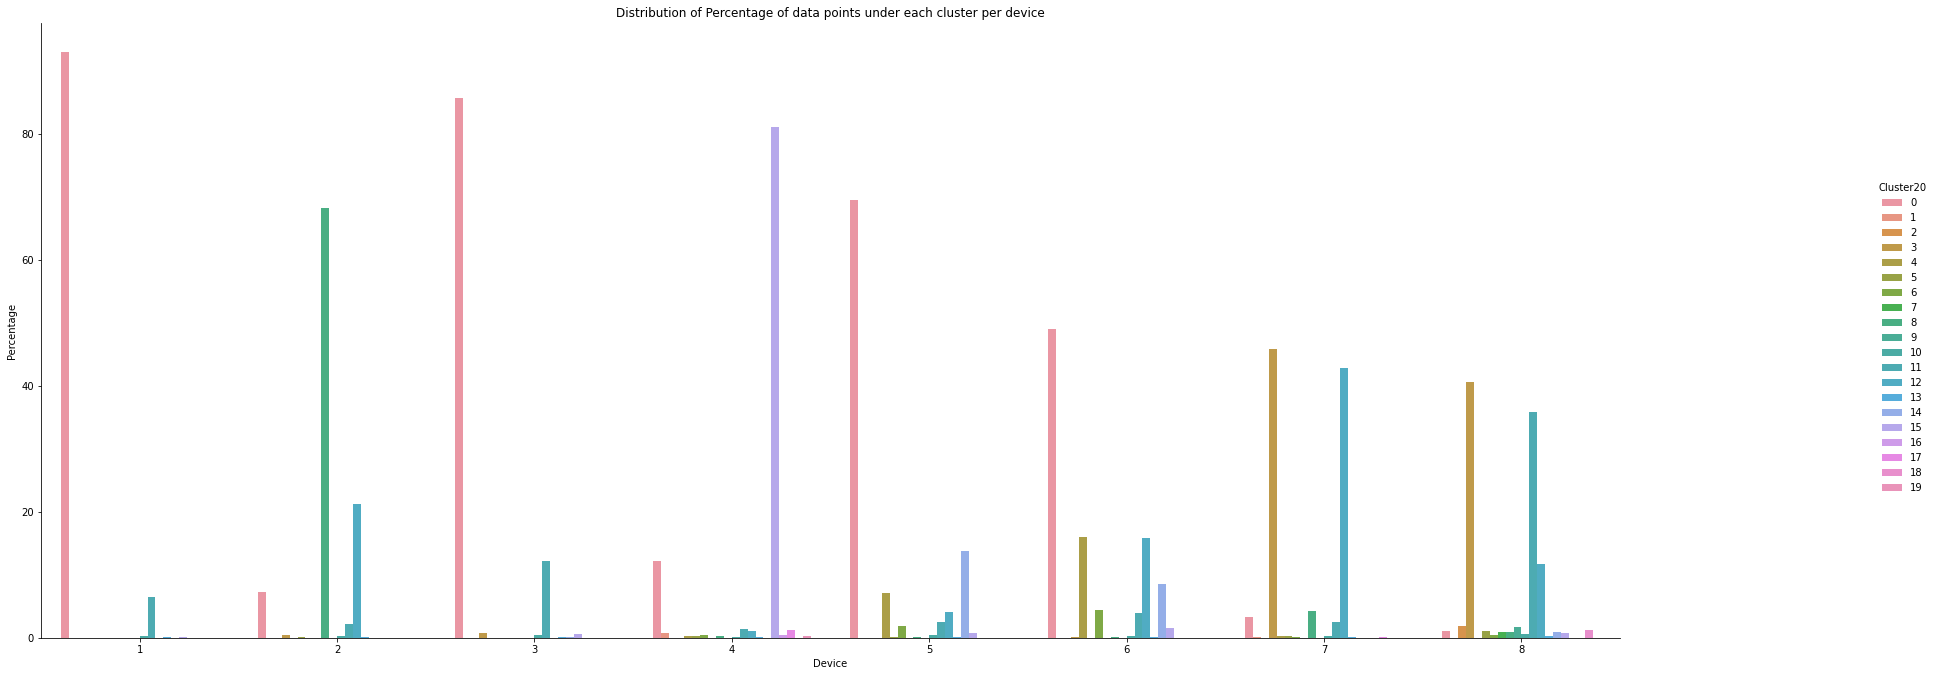

           0         1    2         3         4         5         6    7  \
0  92.964763  0.000000  0.0  0.032402  0.000000  0.000000  0.000000  0.0   
1   7.313749  0.015142  0.0  0.378558  0.000000  0.075712  0.045427  0.0   
2  85.723823  0.000000  0.0  0.831921  0.015406  0.000000  0.000000  0.0   
3  12.173883  0.814864  0.0  0.005706  0.284175  0.313848  0.365205  0.0   
4  69.471995  0.000000  0.0  0.006420  7.093564  0.060985  1.803884  0.0   

           8         9        10         11         12        13         14  \
0   0.000000  0.000000  0.311867   6.419603   0.000000  0.125557   0.000000   
1  68.170806  0.030285  0.272562   2.210781  21.259843  0.196850   0.000000   
2   0.005135  0.000000  0.421096  12.165563   0.025677  0.159195   0.066759   
3   0.325261  0.039944  0.130104   1.336422   1.075072  0.107279   0.000000   
4   0.057776  0.000000  0.398010   2.506821   4.079602  0.125181  13.712085   

          15        16        17   18        19  
0   0.145808  0.00

In [15]:
# Create a pivot table to idenitfy the number of data points for each Device and Cluster pair
kmeans20_pivot =all_benign.pivot_table(['Counter'] , ['Device', 'Cluster20'], aggfunc='sum').reset_index()

# Idenity the percentage of data points under each Device Cluster pair
kmeans20_pivot['Percentage'] = (kmeans20_pivot['Counter']/kmeans20_pivot.groupby("Device")["Counter"].transform('sum')*100)
print("Summary of data points under each device cluster pair")
print(kmeans20_pivot)

# Plot the distrbution of number of data points falling under each cluster for a device
g = sns.factorplot(x='Device', y='Counter', hue='Cluster20', data=kmeans20_pivot, kind='bar')
g.fig.set_size_inches(30,10)
plt.title("Distribution of Number of data points under each cluster per device")
plt.show()

# Plot the distrbution of Percentage of data points falling under each cluster for a device
g = sns.factorplot(x='Device', y='Percentage', hue='Cluster20', data=kmeans20_pivot, kind='bar')
g.fig.set_size_inches(30,10)
plt.title("Distribution of Percentage of data points under each cluster per device")
plt.show()

# Create a dataframe for percentage distribution into clusters for each device. There are nine rows in the dataframe
# Each row corresponds to the cluster distribution for each device

numclusters = 20
clustergroup = pd.DataFrame(np.zeros((8, numclusters)))
for i in np.arange(1,9,1):
    for j in range(numclusters):
        row = kmeans20_pivot.loc[(kmeans20_pivot['Device'] == i) & (kmeans20_pivot['Cluster20'] == j)]
        if row.empty == False:
            clustergroup.iat[i-1,j] = row['Percentage']
            
print(clustergroup.head())

# Identify the device clusters based on similarity of distribution with the aim to group the devices into 3,4 and 5 clusters



kmeans5 = KMeans(n_clusters=5, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 5 groups")
print(kmeans5.labels_)

kmeans4 = KMeans(n_clusters=4, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 4 groups")
print(kmeans4.labels_)

kmeans3 = KMeans(n_clusters=3, random_state=0, max_iter = 1000).fit(clustergroup)
print("Devices clusters with 3 groups")
print(kmeans3.labels_)


# Code to find the cluser distances for five device clusters
centroids = kmeans5.cluster_centers_


# find the distance between the five cluster centroid
distance = spatial.distance.cdist(centroids,centroids)
distance = pd.DataFrame(distance)
print("Distance between clusters")
print(distance.head())